In [448]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas_profiling as pp

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/model.h5
/kaggle/input/best_model.h5
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt


In [449]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

In [450]:
from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

In [451]:
sample_sub_csv = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv')
train_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [452]:
flag = 0 
for column in test_df.columns:
    if(column == "SalePrice"):
        flag = 1
if(flag == 1):
    print("There is SalePrice beware ")
else:
    print("You need to predict SalePrice")

You need to predict SalePrice


In [453]:
# We have not removed the SalePrice to analyse the Missing Values and do class-conditions Regression
print("The number of columns before making the augmentation = ",train_df.shape[1])
train_df.drop(['Alley', 'Exterior1st', 'Exterior2nd', 'FireplaceQu', 'Fence', 'MiscFeature'],axis = 1, inplace = True)
train_df.drop(['PoolQC', 'Utilities', '3SsnPorch', 'BsmtFinSF2', 'PoolArea', 'Street','MiscVal'],axis = 1, inplace = True)
train_df.drop(['EnclosedPorch','ScreenPorch','LotShape','KitchenAbvGr','GarageQual','LowQualFinSF','RoofMatl','Heating','OpenPorchSF','MasVnrArea','LandSlope'], axis = 1, inplace = True)
train_df.drop(['GarageCond','BsmtHalfBath','BsmtFinType2','GarageCars','Condition2','WoodDeckSF'],axis = 1, inplace = True)
print("The number of columns after dropping the missing valued columns and the predicting variable = ",train_df.shape[1])

The number of columns before making the augmentation =  81
The number of columns after dropping the missing valued columns and the predicting variable =  51


In [454]:
print("The number of columns before making augmenation in Test set",test_df.shape[1])
test_df.drop(['Alley', 'Exterior1st', 'Exterior2nd', 'FireplaceQu', 'Fence', 'MiscFeature'],axis = 1, inplace = True)
test_df.drop(['PoolQC', 'Utilities', '3SsnPorch', 'BsmtFinSF2', 'PoolArea', 'Street','MiscVal'],axis = 1, inplace = True)
test_df.drop(['EnclosedPorch','ScreenPorch','LotShape','KitchenAbvGr','GarageQual','LowQualFinSF','RoofMatl','Heating','OpenPorchSF','MasVnrArea','LandSlope'], axis = 1, inplace = True)
test_df.drop(['GarageCond','BsmtHalfBath','BsmtFinType2','GarageCars','Condition2','WoodDeckSF'],axis = 1, inplace = True)
print("The number of columns after dropping the missing valued columns = ",test_df.shape[1])

The number of columns before making augmenation in Test set 80
The number of columns after dropping the missing valued columns =  50


In [455]:
def check_mismatch(column, train_df, test_df):
    if(train_df[column].isnull().any()):
        print("Number of rows haivng the NUll value train_df = ",train_df[column].isnull().sum())
    else:
        print("There is no Null value in train_df column ",column)
    
    if(test_df[column].isnull().any()):
        print("Number of rows haivng the NUll value in test_df = ",test_df[column].isnull().sum())
    else:
        print("There is no Null value in train_df column ",column)    

In [456]:
def check_missing(column, check_df):
    if(check_df[column].isnull().any()):
        print("Number of rows having the NULL value in ",check_df," are ",check_df[column].isnull().sum())
    else:
        print("There is no NULL vale in the column", column)

In [457]:
def encode_categorical(df, column_list, index_list):
    for column in column_list:
        df[column] = df[column].astype('str')
        encoder = preprocessing.LabelEncoder()
        encoded_list = encoder.fit_transform(df[column])
#         print(encoded_list)
#         print(len(encoded_list))
        encoded_series = pd.Series(encoded_list, index = index_list)
        df[column] = encoded_series
        print("The ", column, "is encoded ")
    return(df)

In [458]:
# Numeric types need to do MinxMaxScaler
def scale_data(df, column_list, index_list):
    for column in column_list:
        df[column] = df[column].astype('float')
        encoder = preprocessing.MinMaxScaler()
        df[column] = encoder.fit_transform(df[column].values.reshape(-1,1))
        print("The ",column, "is encoded")
    return(df)

In [459]:
Y_actual = train_df['SalePrice'].values
print(Y_actual)

[208500 181500 223500 ... 266500 142125 147500]


In [460]:
reg_enc = preprocessing.MinMaxScaler()
Y_enc_train = train_df['SalePrice'].values.reshape(-1,1)
Y_enc_train = reg_enc.fit_transform(Y_enc_train)

Y_train = []
for i in range(len(Y_enc_train)):
    Y_train.append(Y_enc_train[i][0])

Y_train = np.array(Y_train)
    
print(len(Y_train))
print(Y_train.shape)

1460
(1460,)


In [461]:
# print(Y_train.shape)
print(Y_train)

[0.24107763 0.20358284 0.26190807 ... 0.321622   0.14890293 0.15636717]


In [462]:
train_df.drop('SalePrice',axis = 1, inplace = True)

In [463]:
index_list = []
for i in range(1, 2920):
    index_list.append(i)

In [464]:
train_ending = 1460       # This is the Id numbeer
train_starting = 1
test_starting = 1461
test_ending = 2919

In [465]:
# Merge the two datafames to enocde them properly
train_df.set_index('Id', inplace = True)
test_df.set_index('Id', inplace = True)

In [466]:
# Merging the two dataframes using Id as the index
frames = [train_df, test_df]
combined_df = pd.concat(frames)

In [467]:
#pp.ProfileReport(combined_df)

In [468]:
columns_encoded = 0
categorical_list = ['MSSubClass','MSZoning','BldgType','YearBuilt','YrSold','BsmtFullBath','CentralAir','Condition1','Electrical','ExterCond','YearRemodAdd']
columns_encoded += len(categorical_list)
combined_df = encode_categorical(combined_df, categorical_list, index_list)

print("Number of columns encoded ",columns_encoded)

The  MSSubClass is encoded 
The  MSZoning is encoded 
The  BldgType is encoded 
The  YearBuilt is encoded 
The  YrSold is encoded 
The  BsmtFullBath is encoded 
The  CentralAir is encoded 
The  Condition1 is encoded 
The  Electrical is encoded 
The  ExterCond is encoded 
The  YearRemodAdd is encoded 
Number of columns encoded  11


In [469]:
categorical_list = ['ExterQual','Fireplaces','Foundation','FullBath','Functional','GarageYrBlt','HalfBath','HeatingQC','HouseStyle','KitchenQual','LandContour']
columns_encoded += len(categorical_list)
combined_df = encode_categorical(combined_df, categorical_list, index_list)

print("Number of columns encoded ",columns_encoded)

The  ExterQual is encoded 
The  Fireplaces is encoded 
The  Foundation is encoded 
The  FullBath is encoded 
The  Functional is encoded 
The  GarageYrBlt is encoded 
The  HalfBath is encoded 
The  HeatingQC is encoded 
The  HouseStyle is encoded 
The  KitchenQual is encoded 
The  LandContour is encoded 
Number of columns encoded  22


In [470]:
categorical_list = ['LotConfig','MasVnrType','MoSold','Neighborhood','OverallCond','OverallQual','PavedDrive','RoofStyle','SaleCondition','SaleType','TotRmsAbvGrd']
columns_encoded += len(categorical_list)
combined_df = encode_categorical(combined_df, categorical_list, index_list)

print("Number of columns encoded ",columns_encoded)

The  LotConfig is encoded 
The  MasVnrType is encoded 
The  MoSold is encoded 
The  Neighborhood is encoded 
The  OverallCond is encoded 
The  OverallQual is encoded 
The  PavedDrive is encoded 
The  RoofStyle is encoded 
The  SaleCondition is encoded 
The  SaleType is encoded 
The  TotRmsAbvGrd is encoded 
Number of columns encoded  33


In [471]:
#pp.ProfileReport(combined_df)

In [472]:
scale_column_list = ['BsmtUnfSF', '2ndFlrSF', 'BsmtFinSF1', 'GarageArea', 'GrLivArea', 'LotArea', 'TotalBsmtSF','1stFlrSF']
columns_encoded += len(scale_column_list)
combined_df = scale_data(combined_df, scale_column_list, index_list)

print("Number of columns encoded ",columns_encoded)

The  BsmtUnfSF is encoded
The  2ndFlrSF is encoded
The  BsmtFinSF1 is encoded
The  GarageArea is encoded
The  GrLivArea is encoded
The  LotArea is encoded
The  TotalBsmtSF is encoded
The  1stFlrSF is encoded
Number of columns encoded  41


In [473]:
combined_df['GarageType'] = combined_df['GarageType'].fillna(value = 'None')

In [474]:
combined_df['GarageFinish'] = combined_df['GarageFinish'].fillna(value = 'None')
combined_df['BsmtQual'] = combined_df['BsmtQual'].fillna(value = 'None')
combined_df['BsmtFinType1'] = combined_df['BsmtFinType1'].fillna(value = 'None')
combined_df['BsmtExposure'] = combined_df['BsmtExposure'].fillna(value = 'None')
combined_df['BsmtCond'] = combined_df['BsmtCond'].fillna(value = 'None')

In [475]:
categorical_list = ['GarageType','GarageFinish', 'BsmtQual', 'BsmtFinType1', 'BsmtExposure','BsmtCond']
columns_encoded += len(categorical_list)
combined_df = encode_categorical(combined_df, categorical_list, index_list)
print(columns_encoded)

The  GarageType is encoded 
The  GarageFinish is encoded 
The  BsmtQual is encoded 
The  BsmtFinType1 is encoded 
The  BsmtExposure is encoded 
The  BsmtCond is encoded 
47


In [476]:
combined_df['LotFrontage'] = combined_df['LotFrontage'].fillna(value = 0)
scale_list = ['LotFrontage']
columns_encoded += len(scale_list)
combined_df = scale_data(combined_df, scale_list, index_list)
print(columns_encoded)

The  LotFrontage is encoded
48


In [477]:
combined_df.shape

(2919, 49)

In [478]:
# The only non-enocded value is the ID column which I will use to spilt to data into train and test as it was before
# The data may sound crazy as LotArea is being treated as negative and Garage Area has negative values
# But they have no meaning to us as our network needs to learn the values properly

# We again need to scale the categorical values so that our network can learn properly.

In [479]:
combined_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,LandContour,LotConfig,Neighborhood,Condition1,BldgType,HouseStyle,...,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageArea,PavedDrive,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,10,3,0.207668,0.033420,3,4,5,2,0,5,...,0,1,94,2,0.368280,2,4,2,8,4
2,5,3,0.255591,0.038795,3,2,24,1,0,2,...,1,1,67,2,0.309140,2,7,1,8,4
3,10,3,0.217252,0.046507,3,4,5,2,0,5,...,1,1,92,2,0.408602,2,11,2,8,4
4,11,3,0.191693,0.038561,3,0,6,2,0,5,...,1,5,89,3,0.431452,2,4,0,8,0
5,10,3,0.268371,0.060576,3,2,15,2,0,5,...,1,1,91,2,0.561828,2,3,2,8,4


In [480]:
l1 = ['MSSubClass','MSZoning','BldgType','YearBuilt','YrSold','BsmtFullBath','CentralAir','Condition1','Electrical','ExterCond','YearRemodAdd']
l2 = ['ExterQual','Fireplaces','Foundation','FullBath','Functional','GarageYrBlt','HalfBath','HeatingQC','HouseStyle','KitchenQual','LandContour']
l3 = ['LotConfig','MasVnrType','MoSold','Neighborhood','OverallCond','OverallQual','PavedDrive','RoofStyle','SaleCondition','SaleType','TotRmsAbvGrd']
l4 = ['GarageType','GarageFinish', 'BsmtQual', 'BsmtFinType1', 'BsmtExposure','BsmtCond']

In [481]:
column_list = l1 + l2 + l3 + l4
combined_df = scale_data(combined_df, column_list, index_list)

The  MSSubClass is encoded
The  MSZoning is encoded
The  BldgType is encoded
The  YearBuilt is encoded
The  YrSold is encoded
The  BsmtFullBath is encoded
The  CentralAir is encoded
The  Condition1 is encoded
The  Electrical is encoded
The  ExterCond is encoded
The  YearRemodAdd is encoded
The  ExterQual is encoded
The  Fireplaces is encoded
The  Foundation is encoded
The  FullBath is encoded
The  Functional is encoded
The  GarageYrBlt is encoded
The  HalfBath is encoded
The  HeatingQC is encoded
The  HouseStyle is encoded
The  KitchenQual is encoded
The  LandContour is encoded
The  LotConfig is encoded
The  MasVnrType is encoded
The  MoSold is encoded
The  Neighborhood is encoded
The  OverallCond is encoded
The  OverallQual is encoded
The  PavedDrive is encoded
The  RoofStyle is encoded
The  SaleCondition is encoded
The  SaleType is encoded
The  TotRmsAbvGrd is encoded
The  GarageType is encoded
The  GarageFinish is encoded
The  BsmtQual is encoded
The  BsmtFinType1 is encoded
The  Bs

In [482]:
# Split it as it was before
train_df = combined_df[:1460]
test_df = combined_df[1460:]

In [483]:
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,LandContour,LotConfig,Neighborhood,Condition1,BldgType,HouseStyle,...,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageArea,PavedDrive,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,0.666667,0.6,0.207668,0.033420,1.0,1.0,0.208333,0.250,0.0,0.714286,...,0.00,0.166667,0.912621,0.666667,0.368280,1.0,0.363636,0.50,0.888889,0.8
2,0.333333,0.6,0.255591,0.038795,1.0,0.5,1.000000,0.125,0.0,0.285714,...,0.25,0.166667,0.650485,0.666667,0.309140,1.0,0.636364,0.25,0.888889,0.8
3,0.666667,0.6,0.217252,0.046507,1.0,1.0,0.208333,0.250,0.0,0.714286,...,0.25,0.166667,0.893204,0.666667,0.408602,1.0,1.000000,0.50,0.888889,0.8
4,0.733333,0.6,0.191693,0.038561,1.0,0.0,0.250000,0.250,0.0,0.714286,...,0.25,0.833333,0.864078,1.000000,0.431452,1.0,0.363636,0.00,0.888889,0.0
5,0.666667,0.6,0.268371,0.060576,1.0,0.5,0.625000,0.250,0.0,0.714286,...,0.25,0.166667,0.883495,0.666667,0.561828,1.0,0.272727,0.50,0.888889,0.8


In [484]:
train_df.tail()

,MSSubClass,MSZoning,LotFrontage,LotArea,LandContour,LotConfig,Neighborhood,Condition1,BldgType,HouseStyle,...,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageArea,PavedDrive,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1456,0.666667,0.6,0.198083,0.030929,1.0,1.0,0.333333,0.25,0.0,0.714286,...,0.25,0.166667,0.873786,0.666667,0.309140,1.0,0.909091,0.25,0.888889,0.8
1457,0.333333,0.6,0.271565,0.055505,1.0,1.0,0.583333,0.25,0.0,0.285714,...,0.50,0.166667,0.669903,1.000000,0.336022,1.0,0.363636,1.00,0.888889,0.8
1458,0.733333,0.6,0.210863,0.036187,1.0,1.0,0.250000,0.25,0.0,0.714286,...,0.50,0.166667,0.320388,0.666667,0.169355,1.0,0.636364,1.00,0.888889,0.8
1459,0.333333,0.6,0.217252,0.039342,1.0,1.0,0.500000,0.25,0.0,0.285714,...,0.00,0.166667,0.398058,1.000000,0.161290,1.0,0.545455,1.00,0.888889,0.8
1460,0.333333,0.6,0.239617,0.040370,1.0,1.0,0.291667,0.25,0.0,0.285714,...,0.00,0.166667,0.543689,0.000000,0.185484,1.0,0.727273,0.50,0.888889,0.8


In [485]:
test_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,LandContour,LotConfig,Neighborhood,Condition1,BldgType,HouseStyle,...,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageArea,PavedDrive,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,0.333333,0.4,0.255591,0.048246,1.000000,1.0,0.500000,0.125,0.0,0.285714,...,0.00,0.166667,0.504854,1.000000,0.490591,1.0,0.727273,1.0,0.888889,0.8
1462,0.333333,0.6,0.258786,0.060609,1.000000,0.0,0.500000,0.250,0.0,0.285714,...,0.00,0.166667,0.475728,1.000000,0.209677,1.0,0.727273,1.0,0.888889,0.8
1463,0.666667,0.6,0.236422,0.058566,1.000000,1.0,0.333333,0.250,0.0,0.714286,...,0.25,0.166667,0.854369,0.000000,0.323925,1.0,0.454545,1.0,0.888889,0.8
1464,0.666667,0.6,0.249201,0.040562,1.000000,1.0,0.333333,0.250,0.0,0.714286,...,0.25,0.166667,0.864078,0.000000,0.315860,1.0,0.727273,1.0,0.888889,0.8
1465,0.000000,0.6,0.137380,0.017318,0.333333,1.0,0.916667,0.250,1.0,0.285714,...,0.00,0.166667,0.805825,0.666667,0.340054,1.0,0.000000,1.0,0.888889,0.8


In [486]:
test_df.tail()

,MSSubClass,MSZoning,LotFrontage,LotArea,LandContour,LotConfig,Neighborhood,Condition1,BldgType,HouseStyle,...,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageArea,PavedDrive,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
2915,0.133333,0.8,0.067093,0.002973,1.0,1.0,0.416667,0.25,0.75,0.714286,...,0.00,1.000000,1.000000,0.333333,0.000000,1.0,0.727273,0.0,0.888889,0.8
2916,0.133333,0.8,0.067093,0.002776,1.0,1.0,0.416667,0.25,1.00,0.714286,...,0.00,0.666667,0.592233,1.000000,0.192204,1.0,0.545455,0.0,0.888889,0.0
2917,0.333333,0.6,0.511182,0.087406,1.0,1.0,0.458333,0.25,0.00,0.285714,...,0.25,0.833333,0.495146,1.000000,0.387097,1.0,1.000000,0.0,0.888889,0.0
2918,0.933333,0.6,0.198083,0.042726,1.0,1.0,0.458333,0.25,0.00,0.857143,...,0.00,1.000000,1.000000,0.333333,0.000000,1.0,0.818182,0.0,0.888889,0.8
2919,0.666667,0.6,0.236422,0.038921,1.0,1.0,0.458333,0.25,0.00,0.714286,...,0.25,0.166667,0.815534,0.000000,0.436828,1.0,0.181818,0.0,0.888889,0.8


In [487]:
# Drop the indices for the test dataset
train_df = train_df.rename_axis(None)

In [488]:
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,LandContour,LotConfig,Neighborhood,Condition1,BldgType,HouseStyle,...,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageArea,PavedDrive,MoSold,YrSold,SaleType,SaleCondition
1,0.666667,0.6,0.207668,0.033420,1.0,1.0,0.208333,0.250,0.0,0.714286,...,0.00,0.166667,0.912621,0.666667,0.368280,1.0,0.363636,0.50,0.888889,0.8
2,0.333333,0.6,0.255591,0.038795,1.0,0.5,1.000000,0.125,0.0,0.285714,...,0.25,0.166667,0.650485,0.666667,0.309140,1.0,0.636364,0.25,0.888889,0.8
3,0.666667,0.6,0.217252,0.046507,1.0,1.0,0.208333,0.250,0.0,0.714286,...,0.25,0.166667,0.893204,0.666667,0.408602,1.0,1.000000,0.50,0.888889,0.8
4,0.733333,0.6,0.191693,0.038561,1.0,0.0,0.250000,0.250,0.0,0.714286,...,0.25,0.833333,0.864078,1.000000,0.431452,1.0,0.363636,0.00,0.888889,0.0
5,0.666667,0.6,0.268371,0.060576,1.0,0.5,0.625000,0.250,0.0,0.714286,...,0.25,0.166667,0.883495,0.666667,0.561828,1.0,0.272727,0.50,0.888889,0.8


In [489]:
train_df.shape

(1460, 49)

In [490]:
# Create the train_set from the dataframe
X_train = train_df.values
print(X_train.shape)
#Note that we already created the Y_train above

(1460, 49)


In [491]:
# Now we can easily regress with our Keras Feed-Forward Nueral Network
model = Sequential()
model.add(layers.Dense(64, activation = 'relu', input_shape = (49,)))
model.add(layers.BatchNormalization(axis=1))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.BatchNormalization(axis=1))
model.add(layers.Dropout(0.1))

model.add(layers.Dense(16, activation = 'relu'))
model.add(layers.BatchNormalization(axis=1))
model.add(layers.Dropout(0.1))

model.add(layers.Dense(8, activation = 'relu'))
model.add(layers.BatchNormalization(axis=1))
model.add(layers.Dropout(0.1))

model.add(layers.Dense(1, activation = 'relu'))

In [492]:
# All the hyperparameters are here
learning_rate = 0.025
batch_size = 32
epochs = 100

In [493]:
optim = optimizers.Adam(lr = learning_rate)

In [494]:
model.compile(optimizer = optim, loss = 'mean_squared_error', metrics = ['mse'])

In [495]:
checkpoint = ModelCheckpoint("/kaggle/input/best_model.h5", monitor = 'val_loss', save_best_only=True, verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.001)

In [496]:
history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, validation_split = 0.2, callbacks = [reduce_lr, checkpoint])

Train on 1168 samples, validate on 292 samples
Epoch 1/100
1168/1168 [==============================] - 6s 6ms/step - loss: 0.0794 - mean_squared_error: 0.0794 - val_loss: 0.0548 - val_mean_squared_error: 0.0548

Epoch 00001: val_loss improved from inf to 0.05480, saving model to /kaggle/input/best_model.h5
Epoch 2/100
1168/1168 [==============================] - 0s 349us/step - loss: 0.0520 - mean_squared_error: 0.0520 - val_loss: 0.0510 - val_mean_squared_error: 0.0510

Epoch 00002: val_loss improved from 0.05480 to 0.05100, saving model to /kaggle/input/best_model.h5
Epoch 3/100
1168/1168 [==============================] - 0s 327us/step - loss: 0.0474 - mean_squared_error: 0.0474 - val_loss: 0.1005 - val_mean_squared_error: 0.1005

Epoch 00003: val_loss did not improve from 0.05100
Epoch 4/100
1168/1168 [==============================] - 0s 335us/step - loss: 0.0340 - mean_squared_error: 0.0340 - val_loss: 0.0332 - val_mean_squared_error: 0.0332

Epoch 00004: val_loss improved from 

1168/1168 [==============================] - 0s 342us/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0040 - val_mean_squared_error: 0.0040

Epoch 00035: val_loss did not improve from 0.00392
Epoch 36/100
1168/1168 [==============================] - 0s 335us/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0040 - val_mean_squared_error: 0.0040

Epoch 00036: val_loss did not improve from 0.00392
Epoch 37/100
1168/1168 [==============================] - 0s 327us/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0040 - val_mean_squared_error: 0.0040

Epoch 00037: val_loss did not improve from 0.00392
Epoch 38/100
1168/1168 [==============================] - 0s 342us/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0040 - val_mean_squared_error: 0.0040

Epoch 00038: val_loss did not improve from 0.00392
Epoch 39/100
1168/1168 [==============================] - 0s 326us/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.004

1168/1168 [==============================] - 0s 334us/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0040 - val_mean_squared_error: 0.0040

Epoch 00072: val_loss did not improve from 0.00392
Epoch 73/100
1168/1168 [==============================] - 0s 362us/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0040 - val_mean_squared_error: 0.0040

Epoch 00073: val_loss did not improve from 0.00392
Epoch 74/100
1168/1168 [==============================] - 0s 344us/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0040 - val_mean_squared_error: 0.0040

Epoch 00074: val_loss did not improve from 0.00392
Epoch 75/100
1168/1168 [==============================] - 0s 318us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0040 - val_mean_squared_error: 0.0040

Epoch 00075: val_loss did not improve from 0.00392
Epoch 76/100
1168/1168 [==============================] - 0s 350us/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.004

In [497]:
print(X_train.shape)

(1460, 49)


In [498]:
model.load_weights('/kaggle/input/best_model.h5')

In [499]:
# Checking how our model performs on Train Dataset

#our predictions
pred_price = model.predict(X_train)
pred_price = reg_enc.inverse_transform(pred_price)

In [500]:
Y_pred = []
for i in range(len(pred_price)):
    Y_pred.append(pred_price[i][0])

Y_pred = np.array(Y_pred)

print(Y_pred)

[209880.27 192993.86 228584.14 ... 254527.38 132843.86 152168.6 ]


In [501]:
print(Y_actual)

[208500 181500 223500 ... 266500 142125 147500]


In [502]:
X = []
for i in range(len(Y_pred)):
    X.append(i)

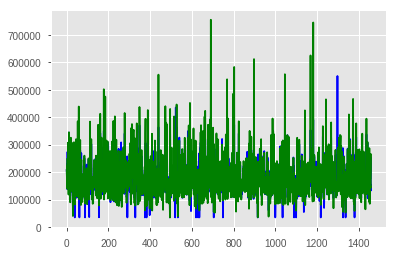

In [503]:
plt.plot(X,Y_pred, c = 'b')
plt.plot(X,Y_actual, c= 'g')
plt.show()

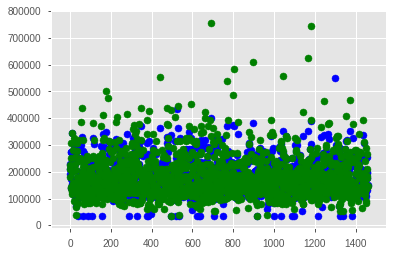

In [504]:
plt.scatter(X,Y_pred, c = 'b')
plt.scatter(X,Y_actual, c= 'g')
plt.show()

In [505]:
test_final = test_df.rename_axis(None, inplace = False)

In [506]:
test_final_arr = test_final.values

In [507]:
predictions = model.predict(test_final_arr)
predictions =  reg_enc.inverse_transform(predictions)

In [508]:
Y_test_predictions = []
for i in range(len(pred_price)):
    Y_test_predictions.append(pred_price[i][0])

Y_test_predictions = np.array(Y_pred)

In [509]:
test_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [510]:
submission = pd.DataFrame()
submission['Id'] = test_df['Id']
submission['SalePrice'] = pd.Series(Y_test_predictions)

In [511]:
submission.head()

,Id,SalePrice
0,1461,209880.265625
1,1462,192993.859375
2,1463,228584.140625
3,1464,137726.703125
4,1465,273548.375000


In [512]:
submission.tail()

,Id,SalePrice
1454,2915,196671.750000
1455,2916,175827.250000
1456,2917,200893.828125
1457,2918,254527.375000
1458,2919,132843.859375


In [513]:
submission.to_csv('submission.csv', index=False)